In [1]:
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.dummy import DummyRegressor
# from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
# from sklearn.compose import TransformedTargetRegressor

import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
CSV_PATH = Path("../data/housing.csv")

df = pd.read_csv(CSV_PATH)
print("Arquivo:", CSV_PATH.resolve())
print("Shape:", df.shape)
display(df.head())

Arquivo: /home/user/Documentos/Ciencia_Dados_UFC/Atividade_3/data/housing.csv
Shape: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
# -------------------------
# 3) Identificar target e features
# -------------------------
# No sklearn, o target clássico chama "MedHouseVal".
# Em alguns CSVs, pode estar como "median_house_value" (ex.: versão do Kaggle).
# Vamos tentar detectar automaticamente; se falhar, defina manualmente.

possible_targets = ["MedHouseVal", "median_house_value", "target", "y"]
TARGET_COL = None
for c in possible_targets:
    if c in df.columns:
        TARGET_COL = c
        break

if TARGET_COL is None:
    raise ValueError(
        "Não consegui identificar a coluna target. "
        "Defina TARGET_COL manualmente (ex.: 'MedHouseVal' ou 'median_house_value')."
    )

X = df.drop(columns=[TARGET_COL]).copy()
y = df[TARGET_COL].copy()

print("TARGET_COL:", TARGET_COL)
print("X shape:", X.shape, "y shape:", y.shape)
display(y.describe())


TARGET_COL: median_house_value
X shape: (20640, 9) y shape: (20640,)


count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [4]:
# -------------------------
# 4) Análise rápida: tipos e faltantes
# -------------------------
display(X.dtypes.value_counts())

missing_ratio = X.isna().mean().sort_values(ascending=False)
print("Top faltantes (%):")
display(missing_ratio.head(15))

# Se houver colunas não numéricas, este notebook trata, mas o California Housing normalmente é todo numérico.
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Numéricas:", len(numeric_features), " | Categóricas:", len(categorical_features))
if len(categorical_features) > 0:
    print("Categóricas:", categorical_features)


float64    8
object     1
Name: count, dtype: int64

Top faltantes (%):


total_bedrooms        0.010029
longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
population            0.000000
households            0.000000
median_income         0.000000
ocean_proximity       0.000000
dtype: float64

Numéricas: 8  | Categóricas: 1
Categóricas: ['ocean_proximity']


In [5]:
# -------------------------
# 5.1) Split treino/teste
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)

# -------------------------
# 5.2) Pré-processamento
# - Imputação: mediana (robusta)
# - Escala: StandardScaler (z-score)
# Observação do material: escala faz diferença para modelos baseados em distância e lineares.
# -------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Se houver categóricas (não comum no California Housing), dá para expandir com OneHotEncoder.
# Aqui, deixo pronto para não quebrar:
from sklearn.preprocessing import OneHotEncoder

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)


Train: (16512, 9) Test: (4128, 9)


In [6]:
# -------------------------
# 6) Baseline (DummyRegressor)
# -------------------------
baseline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DummyRegressor(strategy="mean"))
])

baseline.fit(X_train, y_train)
pred_base = baseline.predict(X_test)

rmse_base = np.sqrt(mean_squared_error(y_test, pred_base))
r2_base = r2_score(y_test, pred_base)

print("=== Baseline (média) ===")
print("RMSE:", rmse_base)
print("R²  :", r2_base)


=== Baseline (média) ===
RMSE: 114485.63543099792
R²  : -0.00021908714592466794


In [7]:
from sklearn.linear_model import Ridge, ElasticNet

pipelines = {
    "Ridge": Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", Ridge(random_state=RANDOM_STATE))
    ]),

    "ElasticNet": Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", ElasticNet(
            random_state=RANDOM_STATE,
            max_iter=200000,
            tol=1e-2
        ))
    ]),

    "KNN": Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", KNeighborsRegressor())
    ]),

    "RandomForest": Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", RandomForestRegressor(
            random_state=RANDOM_STATE,
            n_jobs=1  # <- importante: NÃO paraleliza RF aqui
        ))
    ]),

    "HistGB": Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", HistGradientBoostingRegressor(random_state=RANDOM_STATE))
    ]),
}

param_grids = {
    "Ridge": {"model__alpha": [0.01, 0.1, 1.0, 10.0, 100.0]},

    "ElasticNet": {
        "model__alpha": [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
        "model__l1_ratio": [0.2, 0.5, 0.8]
    },

    "KNN": {
        "model__n_neighbors": [5, 15, 35],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2],
    },

    # Grid bem menor para não travar
    "RandomForest": {
        "model__n_estimators": [200, 400],
        "model__max_depth": [None, 20],
        "model__min_samples_leaf": [1, 5],
        "model__max_features": ["sqrt"],
    },

    "HistGB": {
        "model__learning_rate": [0.03, 0.1],
        "model__max_depth": [None, 5, 10],
        "model__max_iter": [300, 600],
        "model__early_stopping": [True],
    },
}


In [8]:
# -------------------------
# 8) GridSearchCV + Validação cruzada (otimizado)
# - Métrica principal: RMSE (via neg_mean_squared_error -> sqrt)
# - Métrica complementar: R²
# - Ajustes: CV=3 e n_jobs=1 para evitar travar/memória
# -------------------------
from sklearn.model_selection import KFold

cv_fast = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

results = []
best_estimators = {}

for name, pipe in pipelines.items():
    print(f"\n=== GridSearch: {name} ===")

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        scoring={
            "mse": "neg_mean_squared_error",
            "r2": "r2",
        },
        refit="mse",
        cv=cv_fast,
        n_jobs=1,          # <- evita travar com joblib/loky
        verbose=0,
        return_train_score=False,
    )

    grid.fit(X_train, y_train)
    best_estimators[name] = grid.best_estimator_

    best_cv_mse = -grid.best_score_
    best_cv_rmse = np.sqrt(best_cv_mse)

    idx = grid.best_index_
    best_cv_r2 = grid.cv_results_["mean_test_r2"][idx]

    y_pred = grid.best_estimator_.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)

    print("Melhor RMSE (CV):", best_cv_rmse)
    print("R² (CV):", best_cv_r2)
    print("Melhores hiperparâmetros:", grid.best_params_)
    print("Teste RMSE:", test_rmse, "| Teste R²:", test_r2)

    results.append({
        "model": name,
        "cv_rmse": best_cv_rmse,
        "cv_r2": best_cv_r2,
        "test_rmse": test_rmse,
        "test_r2": test_r2,
        "best_params": grid.best_params_,
    })

results_df = pd.DataFrame(results).sort_values(by="test_rmse", ascending=True)
display(results_df)



=== GridSearch: Ridge ===
Melhor RMSE (CV): 68569.92149769638
R² (CV): 0.6481591205766895
Melhores hiperparâmetros: {'model__alpha': 1.0}
Teste RMSE: 70066.02112093245 | Teste R²: 0.6253652564019248

=== GridSearch: ElasticNet ===
Melhor RMSE (CV): 68580.0918311797
R² (CV): 0.6480510301702623
Melhores hiperparâmetros: {'model__alpha': 0.01, 'model__l1_ratio': 0.8}
Teste RMSE: 70051.391409286 | Teste R²: 0.625521686751228

=== GridSearch: KNN ===
Melhor RMSE (CV): 59614.91682448921
R² (CV): 0.7340074976272509
Melhores hiperparâmetros: {'model__n_neighbors': 15, 'model__p': 1, 'model__weights': 'distance'}
Teste RMSE: 58141.360313694364 | Teste R²: 0.7420333777272554

=== GridSearch: RandomForest ===
Melhor RMSE (CV): 50525.06108019705
R² (CV): 0.8089832681938413
Melhores hiperparâmetros: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__n_estimators': 400}
Teste RMSE: 49806.626122882524 | Teste R²: 0.8106926885471504

=== GridSearch: HistGB

,model,cv_rmse,cv_r2,test_rmse,test_r2,best_params
4,HistGB,47958.494205,0.827916,46778.267504,0.833013,"{'model__early_stopping': True, 'model__learni..."
3,RandomForest,50525.061080,0.808983,49806.626123,0.810693,"{'model__max_depth': None, 'model__max_feature..."
2,KNN,59614.916824,0.734007,58141.360314,0.742033,"{'model__n_neighbors': 15, 'model__p': 1, 'mod..."
1,ElasticNet,68580.091831,0.648051,70051.391409,0.625522,"{'model__alpha': 0.01, 'model__l1_ratio': 0.8}"
0,Ridge,68569.921498,0.648159,70066.021121,0.625365,{'model__alpha': 1.0}


In [9]:
# -------------------------
# 9) Ranking + modelo mais promissor
# Critério: menor RMSE no teste (e consistência com CV)
# -------------------------
display(results_df[["model", "cv_rmse", "cv_r2", "test_rmse", "test_r2"]])

best_model_name = results_df.iloc[0]["model"]
best_model = best_estimators[best_model_name]
best_params = results_df.iloc[0]["best_params"]

print("=== MODELO MAIS PROMISSOR ===")
print("Modelo:", best_model_name)
print("Hiperparâmetros:", best_params)


,model,cv_rmse,cv_r2,test_rmse,test_r2
4,HistGB,47958.494205,0.827916,46778.267504,0.833013
3,RandomForest,50525.061080,0.808983,49806.626123,0.810693
2,KNN,59614.916824,0.734007,58141.360314,0.742033
1,ElasticNet,68580.091831,0.648051,70051.391409,0.625522
0,Ridge,68569.921498,0.648159,70066.021121,0.625365


=== MODELO MAIS PROMISSOR ===
Modelo: HistGB
Hiperparâmetros: {'model__early_stopping': True, 'model__learning_rate': 0.1, 'model__max_depth': None, 'model__max_iter': 300}


=== Avaliação final (hold-out) ===
Modelo: HistGB
RMSE : 46778.26750386809
R²   : 0.8330134830424543


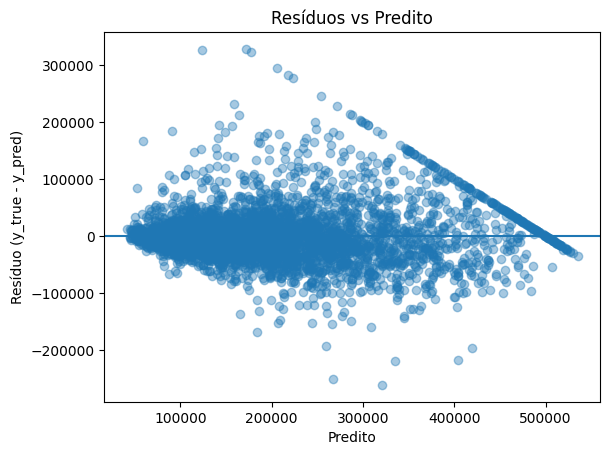

In [10]:
# -------------------------
# 10) Avaliação final + Resíduos
# -------------------------
y_pred_best = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))  # <- sem squared=False
r2 = r2_score(y_test, y_pred_best)

print("=== Avaliação final (hold-out) ===")
print("Modelo:", best_model_name)
print("RMSE :", rmse)
print("R²   :", r2)

residuals = y_test - y_pred_best

plt.figure()
plt.scatter(y_pred_best, residuals, alpha=0.4)
plt.axhline(0)
plt.xlabel("Predito")
plt.ylabel("Resíduo (y_true - y_pred)")
plt.title("Resíduos vs Predito")
plt.show()
